In [79]:
# 使用乳腺癌数据集 实现深度学习的逻辑回归
# 逻辑回归其实就是一个二分类问题，乳腺癌数据集刚好也是一个分类问题
from sklearn.datasets import load_breast_cancer
import torch
from sklearn.model_selection import train_test_split
import numpy as np

In [80]:
# 处理数据集
X,y = load_breast_cancer(return_X_y=True)
X = torch.tensor(data=X, dtype=torch.float32)
y = torch.tensor(data=y, dtype=torch.float32).view(-1,1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 0)
# 规范化
mu = X_train.mean(axis=0)
_std = X_train.std(axis=0) + 1e-6
X_train = (X_train - mu) / _std
X_test = (X_test - mu) / _std

In [81]:
# 定义模型
class LogisticRegression(object):
    def __init__(self, max_iter = 1000, learning_rate = 1e-2) -> None:
        # 初始化
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.n_features = None
        self.w = None
        self.b = None
        self.losses = []
        self.trainaccs = []
        self.testacces = []
        # 保存最好的模型(监控测试集的准确率，只要比上一次好，就保存下来)
        self.besew = None
        self.bestb = None
    
    def _logistic_regression(self, X):
        """
        逻辑回归的正向传播过程
        """
        return torch.sigmoid(X @ self.w + self.b)

    def _get_loss(self, y_true, y_pred):
        """
        利用 MSE 衡量误差
        """
        return ((y_true - y_pred) ** 2).mean()
    
    def _get_acc(self,X,y):
        """
        计算准确率
        """
        y_pred = self.predit(X=X)
        y_test = y.view(-1)
        acc = (y_pred == y_test).to(torch.float32).mean()
        return acc


    def fit(self, X, y):
        """
        训练过程
        """
        self.n_features = X.size(1)
        self.w = torch.randn(size=(self.n_features,1),requires_grad=True)
        self.b = torch.zeros(size=(1,),requires_grad=True)

        # 梯度下降
        for step in range(self.max_iter):
            # 第一步：正向传播
            y_pred = self._logistic_regression(X = X)

            # 第二步：求损失函数
            loss = self._get_loss(y_true=y,y_pred=y_pred)
            self.losses.append(loss.data.cpu().item())
            self.trainaccs.append(self._get_acc(X=X_train,y=y_train))
            self.testacces.append(self._get_acc(X=X_test,y=y_test))

            # 第三步：反向传播
            loss.backward()

            # 第四步：优化一步
            self.w.data = self.w.data - (self.learning_rate * self.w.grad)
            self.b.data = self.b.data - (self.learning_rate * self.b.grad)

            # 第五步：清空梯度
            self.w.grad.zero_()
            self.b.grad.zero_()

            # 第六步：判断是否继续迭代
            # 方法一：控制损失不能低于某个值
            # 方法二：控制两个迭代之间的损失下降不能小于某个值
            if (len(self.losses) > 2):
                if np.abs(self.losses[-1] - self.losses[-2]).item() < 1e-5:
                    print(f"提前终止迭代，总共迭代 {step+1} 次")
                    break

    def predit(self,X):
        # 推理
        y_pred = self._logistic_regression(X=X)
        return (y_pred >= 0.5).to(torch.long).view(-1)

In [85]:
# 构建模型
lr = LogisticRegression(max_iter=10000,learning_rate=1e-2)
# 模型训练
lr.fit(X=X_train,y=y_train)

提前终止迭代，总共迭代 3257 次


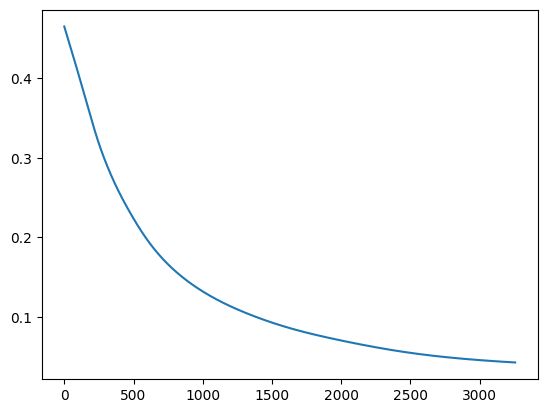

In [86]:
# 画图
from matplotlib import pyplot as plt
plt.plot(lr.losses)

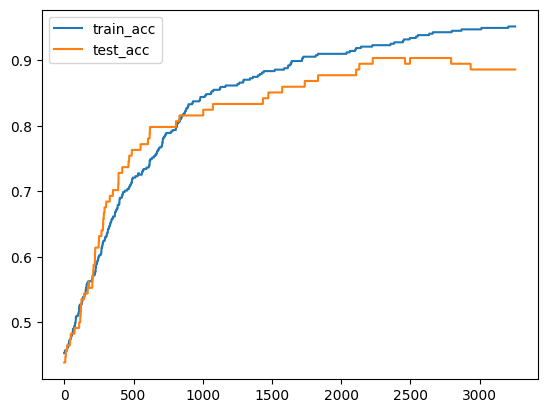

In [87]:
plt.plot(lr.trainaccs,label='train_acc')
plt.plot(lr.testacces,label='test_acc')
plt.legend()